# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

2025-06-20 04:01:38.975597: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
CONFIG = {
    'subset_ratio' : 1.0,
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    
    # GPU Utilization
    'batch_size': 64,           # Fully utilize 48GB VRAM; reduce if OOM
    'buffer_size': 10000,        # Larger shuffle buffer helps training stability
    
    # Model Capacity
    'max_length': 30,            # Reasonable for captions
    'embedding_dim': 512,        # Good for attention + LSTM
    'units': 512,                # LSTM/Attention size
    
    # Training Behavior
    'seed': 42,
    'epochs': 2,                 # Slightly more for small dataset
    'patience': 8,               # Early stopping tolerance
    'learning_rate': 3e-4,       # Lower for small datasets to reduce overfitting
    'grad_clip_value': 5.0,      # Prevent exploding gradients
    'scheduled_sampling_max_prob' : 0.25,    # final ε
    
    # Vocabulary
    'vocab_min_count': 3,        # Include more words for small run
    
    # Output & Precision
    'checkpoint_dir': './checkpoints/10pct',
    'mixed_precision': False,     # RTX 6000 Ada has 4th-gen Tensor Cores—use them
}

In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=64


In [5]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")
    
    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"
    
    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. build (image, caption) list ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        if subset_ratio < 1.0:
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"subset: {len(pairs)} pairs")

        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8*n)],
            pairs[int(0.8*n):int(0.9*n)],
            pairs[int(0.9*n):],
        )
        print(f"split  →  train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)
    
    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image(self, path: tf.Tensor) -> tf.Tensor:
        """
        Read → augment → preprocess for Inception-V3.
        Adds random horizontal flip and random crop (accuracy boost).
        """
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)        # [0,1]

        img = tf.image.random_flip_left_right(img)                 # aug ①

        # Resize so the shorter side = 342 then random-crop 299 × 299
        shape       = tf.shape(img)[:2]                            # (h,w)
        short_side  = tf.cast(tf.reduce_min(shape), tf.float32)
        scale       = 342.0 / short_side
        new_hw      = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])        # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        img = tf.ensure_shape(img, [299, 299, 3])
        return img

    def data_generator(self, data):
        """Generator function for dataset creation."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((self.config['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [6]:
class Encoder(Model):
    """
    Inception-V3 feature extractor with an optional
    `unfreeze_top_layers()` helper for later fine-tuning.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False, weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False                                      # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))                  # L=64 for 8×8 grid

    def unfreeze_top_layers(self, n: int = 2):
        """
        Fine-tune: unfreeze the last *n* Inception blocks (default: mixed9 & mixed10).
        Call **after** initial caption training for best accuracy.
        """
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                             # (B,299,299,3)
        x = self.cnn(x)                                            # (B,8,8,2048)
        return self.reshape(x)                                     # (B,64,2048)

In [7]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

In [8]:
class Decoder(Model):
    """
    Attention decoder with:
      • β-gate
      • **max-out** deep-output layer  (improves accuracy a bit)
    """
    def __init__(self, embedding_dim: int, units: int, vocab_size: int):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation="sigmoid")          # βₜ
        self.lstm      = layers.LSTM(units, return_sequences=True, return_state=True)
        self.dropout   = layers.Dropout(0.3)

        # max-out projection: 2 × units → reduce_max → units
        self.deep_proj = layers.Dense(units * 2)                        # W_o
        self.fc        = layers.Dense(vocab_size)                       # final soft-max

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)               # (B,2048)
        context = self.f_beta(hidden) * context                         # gated

        x = self.embedding(x)                                           # (B,1,E)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)     # (B,1,2048+E)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell,   lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)                               # (B,units)

        # ---------- max-out deep-output layer ----------
        proj = self.deep_proj(tf.concat([lstm_out, context], -1))        # (B,2*units)
        proj = tf.reshape(proj, (-1, self.units, 2))                     # (B,units,2)
        maxout = tf.reduce_max(proj, axis=-1)                            # (B,units)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)                                         # (B,vocab)
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

In [9]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        """Build model for single GPU - no distribution strategy needed."""
        print("Building model for single GPU...")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'], 
            units=self.config['units'], 
            vocab_size=self.processor.vocab_size
        )
        
        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=10000
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        # Set up checkpointing
        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        ckpt = tf.train.Checkpoint(
            encoder=self.encoder, 
            decoder=self.decoder, 
            optimizer=self.optimizer
        )
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=3)
        
        # Try to restore the latest checkpoint
        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")
    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    @tf.function
    def train_step(self,
                   img_tensor: tf.Tensor,
                   target:     tf.Tensor,
                   cap_len:    tf.Tensor) -> tf.Tensor:
        """
        Single step with:
        • β-gated attention + doubly-stochastic regulariser   (already present)
        • **Scheduled sampling** controlled by `self.ss_prob`.
        """
        batch_size = tf.shape(img_tensor)[0]
        hidden     = tf.zeros((batch_size, self.config['units']))
        cell       = tf.zeros_like(hidden)

        start_tok  = self.processor.tokenizer.word_index['<start>']
        dec_input  = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

        attention_accum = None
        total_ce_loss   = 0.0

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)  # (B, L, 2048)

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(
                    dec_input, features, hidden, cell)

                # accumulate α for doubly-stochastic term
                attention_accum = (alpha if attention_accum is None
                                   else attention_accum + alpha)

                # CE loss
                ce_t  = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask  = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                # ---- scheduled sampling decision ----
                # predicted tokens
                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)  # (B,1) → (B,)
                pred_ids = tf.squeeze(pred_ids, -1)

                # Bernoulli mask: 1 → use prediction
                ss_mask = tf.random.uniform((batch_size,)) < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            # normalise CE by real tokens
            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens

            # doubly-stochastic regulariser
            lambda_reg = self.config.get('attention_reg_lambda', 1.0)
            reg_loss   = tf.reduce_mean(tf.square(1.0 - attention_accum))
            loss       = ce_loss + lambda_reg * reg_loss

            if self.config['mixed_precision']:
                loss = tf.cast(loss, tf.float32)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss, variables)

        if self.config['mixed_precision']:
            grads = [tf.cast(g, tf.float32) if g is not None else None
                     for g in grads]

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        return loss

    def beam_search_decode(self,
                           image_path: str,
                           beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        """
        Beam-search inference (≈ +1 BLEU vs greedy).
        `length_penalty` > 0 favours longer sentences.
        """
        # ---- feature extraction (shared across beams) ----
        img_tensor = tf.expand_dims(
            self.processor.load_image(tf.convert_to_tensor(image_path)), 0)
        base_features = self.encoder(img_tensor)                         # (1,L,2048)

        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        Beam = dict  # shorthand for readability
        beams: List[Beam] = [{
            'seq':   [start_id],
            'score': 0.0,
            'hidden': tf.zeros((1, self.config['units'])),
            'cell':   tf.zeros((1, self.config['units'])),
            'alphas': []
        }]

        completed: List[Beam] = []

        for _ in range(self.config['max_length']):
            candidates: List[Beam] = []
            for b in beams:
                last_id = b['seq'][-1]

                # if already ended, keep it
                if last_id == end_id:
                    completed.append(b)
                    continue

                dec_in = tf.expand_dims([last_id], 0)                    # (1,1)
                logits, h, c, alpha = self.decoder(
                    dec_in, base_features, b['hidden'], b['cell'])

                log_probs = tf.nn.log_softmax(logits[0, 0])              # (vocab,)
                top_ids   = tf.math.top_k(log_probs, k=beam_size).indices.numpy()

                for tok in top_ids:
                    tok = int(tok)
                    new_b = {
                        'seq':   b['seq'] + [tok],
                        'score': b['score'] + float(log_probs[tok]),
                        'hidden': h,
                        'cell':   c,
                        'alphas': b['alphas'] + [alpha[0].numpy()]
                    }
                    candidates.append(new_b)

            if not candidates:
                break

            # length-penalised sorting
            def lp(b):
                lp_den = (len(b['seq']) ** length_penalty)
                return b['score'] / lp_den

            candidates.sort(key=lp, reverse=True)
            beams = candidates[:beam_size]

            # if enough completed beams gathered, we can stop
            if len(completed) >= beam_size:
                break

        best = max(completed + beams, key=lambda b: b['score'] / (len(b['seq']) ** length_penalty))

        words = []
        for idx in best['seq']:
            w = self.processor.tokenizer.index_word.get(idx, '')
            if w in ('<start>', '<end>', '<unk>'):
                continue
            words.append(w)

        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate a caption for an image using greedy decoding."""
        # Convert Python string -> tf.Tensor to match load_image() signature
        img_tensor = tf.expand_dims(
            self.processor.load_image(tf.convert_to_tensor(image_path)),
            0
        )

        features = self.encoder(img_tensor)
        hidden  = tf.zeros((1, self.config['units']))
        cell    = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            [self.processor.tokenizer.word_index['<start>']], 0
        )

        result, alphas = [], []

        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(
                dec_input, features, hidden, cell
            )
            pred_id = tf.argmax(logits[0, 0]).numpy()
            word = self.processor.tokenizer.index_word.get(pred_id, '')

            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                result.append(word)

            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([pred_id], 0)

        return (result, alphas) if return_attention else result

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None):
        """
        Same as before *plus*:
        • compute BLEU-4 on a 100-image TRAIN subset each epoch
          and store it in self.train_bleu_log (so we can plot it).
        """
        if epochs is None:
            epochs = self.config['epochs']

        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)
        patience = self.config['patience']
        wait     = 0

        for epoch in range(epochs):
            # ------- scheduled-sampling ε for this epoch -------
            self.ss_prob = self.ss_max_prob * epoch / max(1, epochs - 1)
            print(f"\nEpoch {epoch+1}/{epochs}  (ε = {self.ss_prob:.3f})")

            start, total_loss, step = time.time(), 0.0, 0
            progbar = tf.keras.utils.Progbar(target=None, stateful_metrics=['loss'])

            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = len(self.processor.train_data) // self.config['batch_size'] + 1

                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                progbar.update(batch + 1, values=[('loss', batch_loss)])
                step += 1

            avg_loss = total_loss / step
            self.train_loss_log.append(float(avg_loss))

            # ------- quick BLEU on 100-image TRAIN subset -------
            train_subset = self.processor.train_data[:100]
            train_bleu   = self.evaluate_bleu(train_subset)['bleu-4']
            self.train_bleu_log.append(train_bleu)

            # ------- BLEU on VAL subset -------
            val_bleu = self.evaluate_bleu(val_data[:100])['bleu-4']
            self.val_bleu_log.append(val_bleu)

            # ------- checkpoint & early-stopping -------
            self.ckpt_manager.save()
            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}  "
                  f"train-BLEU={train_bleu:.4f}  val-BLEU={val_bleu:.4f}  "
                  f"time={time.time()-start:.1f}s",
                  flush=True)

        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Visualize attention weights overlaid on the source image."""
        img = np.array(Image.open(image_path).resize((224, 224)))
        fig = plt.figure(figsize=(15, 8))
        
        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption)/3)), t+1)
            ax.set_title(caption[t])
            ax.imshow(img)
            
            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape(attention_shape, attention_shape)
            ax.imshow(alpha, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()
    
    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(self,
             image_path: str,
             filename: str = "caption_audio.mp3",
             beam_size: int = 5,
             length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference) in the following order:
          1. Original image
          2. Ground-truth captions
          3. Generated caption
          4. Audio playback
          5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------- 1. original image ----------
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # ---------- 2. ground-truth captions ----------
        img_name = os.path.basename(image_path)
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(f"- {cap}")
        else:
            print("No ground-truth captions found.")

        # ---------- 3. caption generation ----------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------- 4. audio ----------
        self.speak_caption(caption, filename=filename)

        # ---------- 5. attention plot ----------
        self.plot_attention(image_path, words, attention)

        return caption

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")

In [10]:
processor = DataProcessor(CONFIG)

In [11]:
processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


{'1000092795.jpg': ['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  'Two young , White males are outside near many bushes .',
  'Two men in green shirts are standing in a yard .',
  'A man in a blue shirt standing in a garden .',
  'Two friends enjoy time spent together .'],
 '10002456.jpg': ['Several men in hard hats are operating a giant pulley system .',
  'Workers look down from up above on a piece of equipment .',
  'Two men working on a machine wearing hard hats .',
  'Four men on top of a tall structure .',
  'Three men on a large rig .'],
 '1000268201.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A little girl in a pink dress going into a wooden cabin .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl climbing into a wooden playhouse',
  'A girl going into a wooden building .'],
 '1000344755.jpg': ['Someone in a blue shirt and hat is standing on stair and leaning against

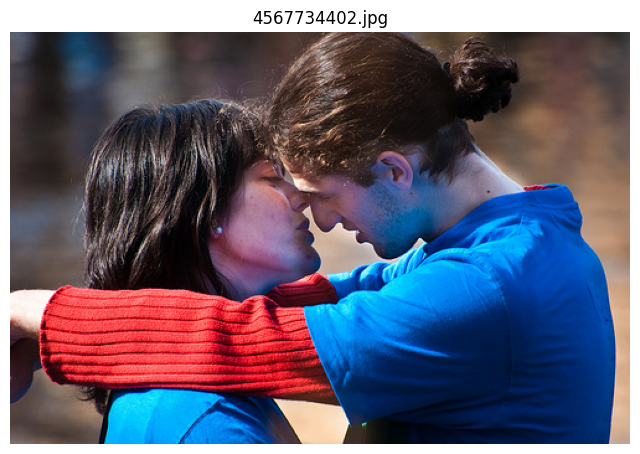

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



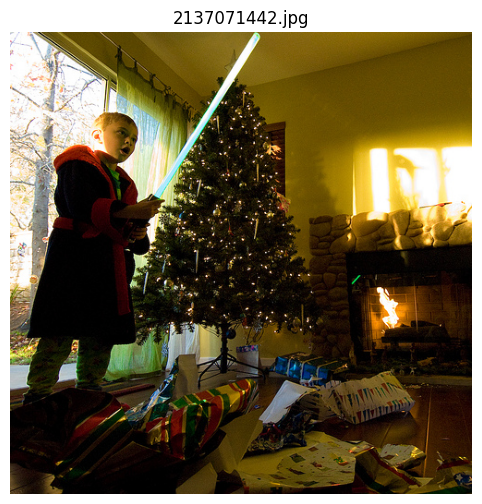

- Young boy holding a light saber in front of a Christmas tree with wrapping paper littering the floor .
- Boy indoors by Christmas tree , playing with green , light-up sword toy .
- A boy holds a light saber in front of a Christmas tree .
- A boy receives a light saber for Christmas .
- A boy looks at a new toy during christmas



In [12]:
processor.display_samples(2)

In [13]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])

max_length set to 25
vocab size = 10009
split  →  train 118132 | val 14767 | test 14767


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> s

In [14]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [15]:
# Build and train model
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model for single GPU...
Restored from checkpoint: ./checkpoints/10pct/ckpt-20


In [16]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        21802784  
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [17]:
# Uncomment to train the model
model.train(train_ds, processor.val_data)


Epoch 1/2  (ε = 0.000)


2025-06-20 04:03:03.772078: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] implementation_selector failed: INVALID_ARGUMENT: Invalid format of input node name:  Expected: {forward_node_name}:{index}


1845/1846 [============================>.] - ETA: 0s - loss: 2.9619

2025-06-20 04:17:16.897838: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] implementation_selector failed: INVALID_ARGUMENT: Invalid format of input node name:  Expected: {forward_node_name}:{index}


1846/1846 [==============================] - 928s 462ms/step - loss: 2.8600


100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


BLEU-1: 0.5545
BLEU-2: 0.3221
BLEU-3: 0.1937
BLEU-4: 0.1221


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


BLEU-1: 0.5299
BLEU-2: 0.2931
BLEU-3: 0.1644
BLEU-4: 0.0966
Epoch 1: loss=3.0088  train-BLEU=0.1221  val-BLEU=0.0966  time=976.9s

Epoch 2/2  (ε = 0.250)
1846/1846 [==============================] - 296s 160ms/step - loss: 2.9016


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


BLEU-1: 0.5466
BLEU-2: 0.3145
BLEU-3: 0.1886
BLEU-4: 0.1204


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


BLEU-1: 0.5353
BLEU-2: 0.2963
BLEU-3: 0.1721
BLEU-4: 0.1068
Epoch 2: loss=3.0088  train-BLEU=0.1204  val-BLEU=0.1068  time=344.7s


([3.0087592601776123, 3.00876522064209],
 [0.09660349652498762, 0.10681128930454363])

In [18]:
# model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=10, lr=1e-5, epochs=2)

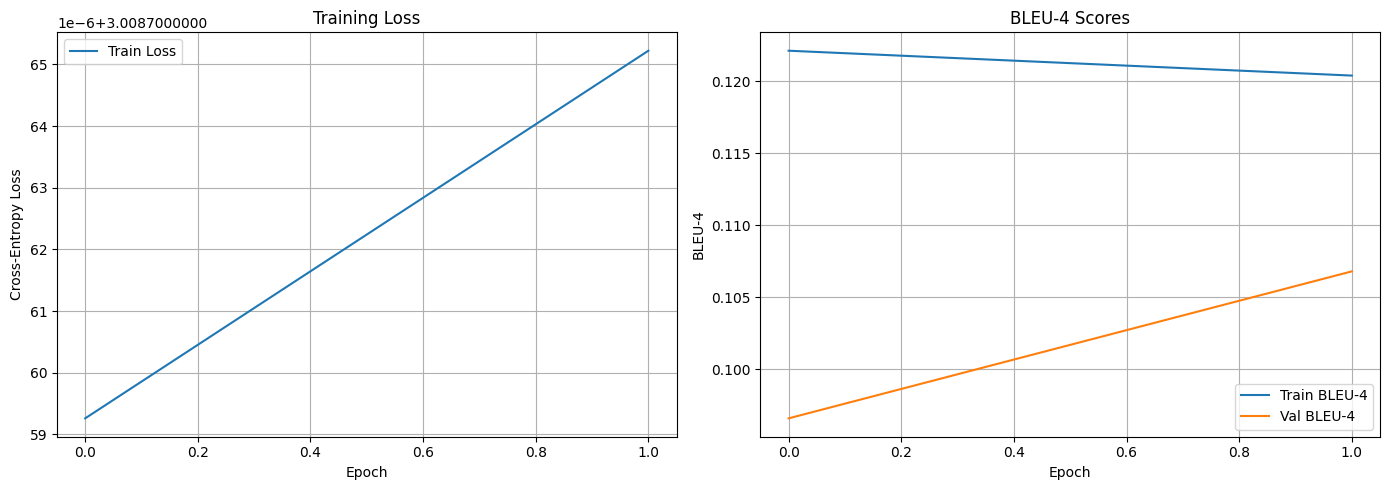

In [19]:
model.plot_history()

In [20]:
# Evaluate on test set
print("Evaluating on test set:")
model.evaluate_bleu(processor.test_data[:20])

Evaluating on test set:


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]

BLEU-1: 0.5096
BLEU-2: 0.2835
BLEU-3: 0.1798
BLEU-4: 0.1270


{'bleu-1': 0.5095785440613027,
 'bleu-2': 0.28345808177903226,
 'bleu-3': 0.17984642068359868,
 'bleu-4': 0.12703926199715815}

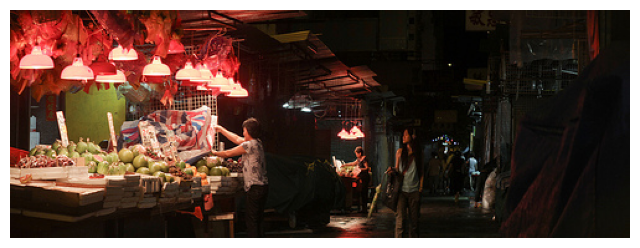

Ground-truth captions:
- In this picture we see an open air market , the tables of produce are illuminated with lamps that have red shades .
- Looks like a farmers market , a few tables with various items displayed .
- Woman setting up a produce stand for the night market .
- Asian fruit stand on the street at night .
- People in a market selling their produce .

Generated caption:
a man in a black shirt is playing a guitar .


Audio saved to caption_audio01.mp3


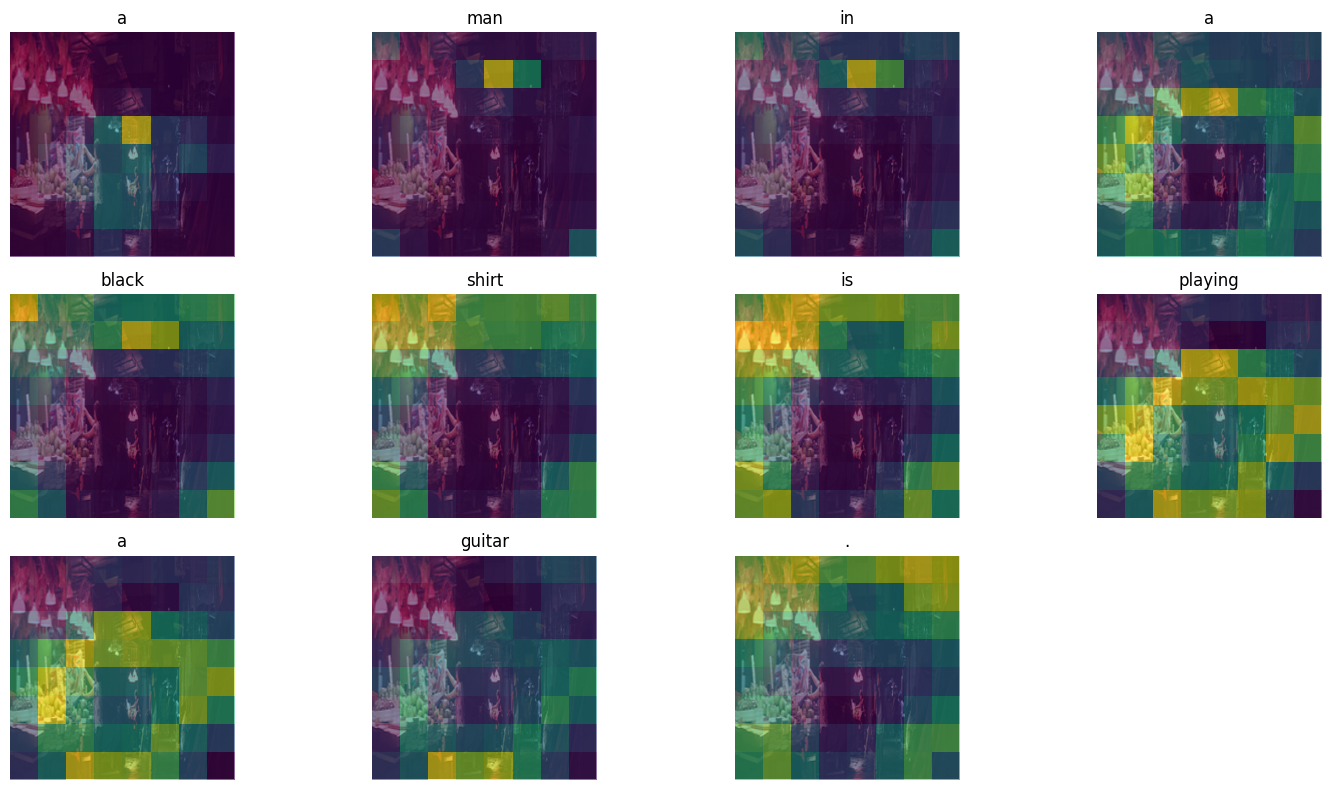

'a man in a black shirt is playing a guitar .'

In [21]:
# Demo with a sample image
sample_img = os.path.join(CONFIG['image_dir'], processor.test_data[0][0])
model.demo(sample_img, filename='caption_audio01.mp3')

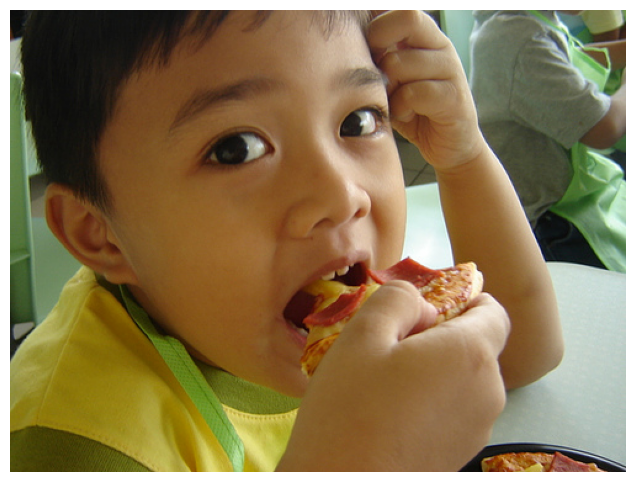

Ground-truth captions:
- A boy in a yellow shirt is eating pizza .
- A little boy eating Hawaiian pizza .
- A little Asian boy eating pizza .
- Young boy eats a slice of pizza
- Boy eating a slice of pizza

Generated caption:
a man in a blue shirt and a woman in a white shirt are standing in front of a building .


Audio saved to caption_audio02.mp3


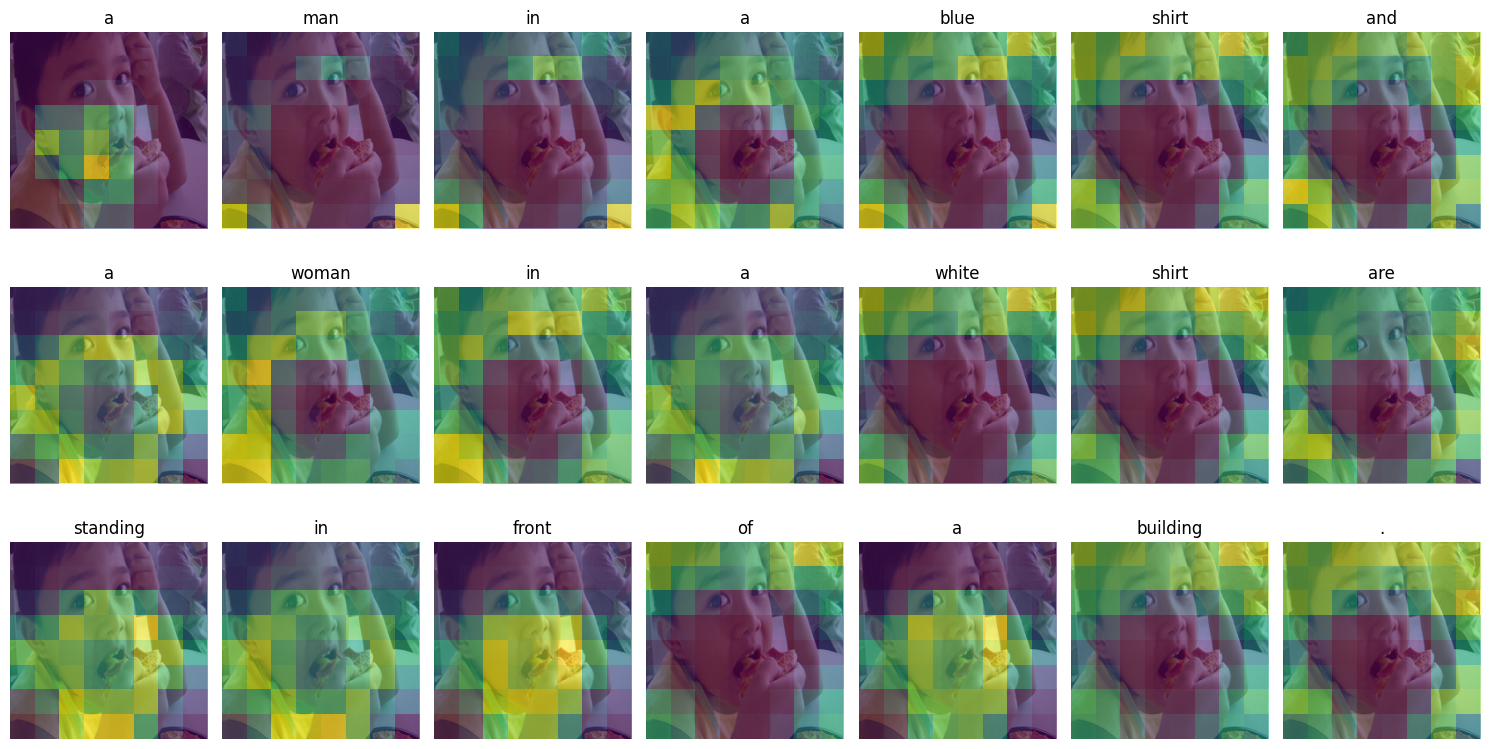

'a man in a blue shirt and a woman in a white shirt are standing in front of a building .'

In [22]:
sample_pair = random.choice(processor.train_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio02.mp3')

In [23]:
# processor.display_samples(10)

In [24]:
# # -------- 1-image over-fit check ---------------------------------
# one_pair   = [processor.train_data[0]]          # (img, caption)
# one_ds     = processor.build_dataset(one_pair,
#                                      shuffle=False, cache=False
#                                     ).repeat()  # infinite

# OVF_CFG = CONFIG.copy()
# OVF_CFG.update({
#     'epochs'       : 1,       # we’ll drive the loop ourselves
#     'batch_size'   : 1,
#     'checkpoint_dir': './checkpoints/onefit'
# })

# one_model = ImageCaptioningModel(OVF_CFG, processor)
# one_model.build_model()

# def show_image(path, title=''):
#     img = Image.open(path)
#     plt.figure(figsize=(6, 4))
#     plt.imshow(img)
#     plt.axis('off')
#     if title: plt.title(title)
#     plt.show()

# img_path = os.path.join(OVF_CFG['image_dir'], one_pair[0][0])
# show_image(img_path, 'Single-image over-fit target')

# # run ~1 000 gradient steps
# steps = 1000
# for step, (img_t, tgt, cap_len) in zip(range(steps), one_ds):
#     loss = one_model.train_step(img_t, tgt, cap_len)
#     if (step+1) % 100 == 0:
#         print(f"step {step+1}: loss={loss.numpy():.3f}")
#         print("→", " ".join(one_model.greedy_decode(img_path)))

# print("\nFinal caption:")
# print(" ".join(one_model.greedy_decode(img_path)))
